In [39]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas_profiling as pp
import re
from sklearn.model_selection import train_test_split,KFold,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics.scorer import make_scorer
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

In [40]:
train = pd.read_csv("train.csv",parse_dates=['intake_datetime','time_in_shelter','date_of_birth','outcome_datetime'])
test  = pd.read_csv("test.csv",parse_dates=['intake_datetime','time_in_shelter','date_of_birth','outcome_datetime'])
submission = pd.DataFrame({'animal_id_outcome':test['animal_id_outcome']})

In [4]:
pp.ProfileReport(train)

In [5]:
pp.ProfileReport(test)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47803 entries, 0 to 47802
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   animal_id_outcome           47803 non-null  object        
 1   dob_year                    47803 non-null  int64         
 2   dob_month                   47803 non-null  int64         
 3   age_upon_intake             47803 non-null  object        
 4   animal_type                 47803 non-null  object        
 5   breed                       47803 non-null  object        
 6   color                       47803 non-null  object        
 7   intake_condition            47803 non-null  object        
 8   intake_type                 47803 non-null  object        
 9   sex_upon_intake             47802 non-null  object        
 10  count                       47803 non-null  int64         
 11  age_upon_intake_(days)      47803 non-null  int64     

##### Column outcome_datetime has missing values 

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31869 entries, 0 to 31868
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   animal_id_outcome           31869 non-null  object        
 1   dob_year                    31869 non-null  int64         
 2   dob_month                   31869 non-null  int64         
 3   age_upon_intake             31869 non-null  object        
 4   animal_type                 31869 non-null  object        
 5   breed                       31869 non-null  object        
 6   color                       31869 non-null  object        
 7   intake_condition            31869 non-null  object        
 8   intake_type                 31869 non-null  object        
 9   sex_upon_intake             31869 non-null  object        
 10  count                       31869 non-null  int64         
 11  age_upon_intake_(days)      31869 non-null  int64     

In [8]:
train.head()

animal_id_outcome  dob_year  dob_month age_upon_intake animal_type  \
0           A006100      2007          7        10 years         Dog   
1           A006100      2007          7         7 years         Dog   
2           A006100      2007          7         6 years         Dog   
3           A047759      2004          4        10 years         Dog   
4           A134067      1997         10        16 years         Dog   

                  breed         color intake_condition      intake_type  \
0  Spinone Italiano Mix  Yellow/White           Normal            Stray   
1  Spinone Italiano Mix  Yellow/White           Normal    Public Assist   
2  Spinone Italiano Mix  Yellow/White           Normal    Public Assist   
3             Dachshund      Tricolor           Normal  Owner Surrender   
4     Shetland Sheepdog   Brown/White          Injured    Public Assist   

  sex_upon_intake  count  age_upon_intake_(days)  age_upon_intake_(years)  \
0   Neutered Male      1                    3650                     10.0   
1   Neutered Male      1                    2555                      7.0   
2   Neutered Male      1                    2190                      6.0   
3   Neutered Male      1                    3650                     10.0   
4   Neutered Male      1                    5840                     16.0   

  age_upon_intake_age_group     intake_datetime  intake_month  intake_year  \
0               (7.5, 10.0] 2017-12-07 00:00:00            12         2017   
1                (5.0, 7.5] 2014-12-19 10:21:00            12         2014   
2                (5.0, 7.5] 2014-03-07 14:26:00             3         2014   
3               (7.5, 10.0] 2014-04-02 15:55:00             4         2014   
4              (15.0, 17.5] 2013-11-16 09:02:00            11         2013   

  intake_monthyear intake_weekday  intake_hour  intake_number  \
0          2017-12       Thursday           14            1.0   
1          2014-12         Friday           10            2.0   
2          2014-03         Friday           14            3.0   
3          2014-04      Wednesday           15            1.0   
4          2013-11       Saturday            9            1.0   

             time_in_shelter  time_in_shelter_days age_upon_outcome  \
0  0 days 14:07:00.000000000              0.588194         10 years   
1  1 days 06:14:00.000000000              1.259722          7 years   
2  1 days 02:44:00.000000000              1.113889          6 years   
3  4 days 23:17:00.000000000              4.970139         10 years   
4  0 days 02:52:00.000000000              0.119444         16 years   

  date_of_birth sex_upon_outcome  age_upon_outcome_(days)  \
0    2007-07-09    Neutered Male                     3650   
1    2007-07-09    Neutered Male                     2555   
2    2007-07-09    Neutered Male                     2190   
3    2004-04-02    Neutered Male                     3650   
4    1997-10-16    Neutered Male                     5840   

   age_upon_outcome_(years) age_upon_outcome_age_group    outcome_datetime  \
0                      10.0                (7.5, 10.0] 2017-12-07 14:07:00   
1                       7.0                 (5.0, 7.5] 2014-12-20 16:35:00   
2                       6.0                 (5.0, 7.5]                 NaT   
3                      10.0                (7.5, 10.0] 2014-04-07 15:12:00   
4                      16.0               (15.0, 17.5] 2013-11-16 11:54:00   

   outcome_month  outcome_year outcome_monthyear outcome_weekday  \
0             12          2017           2017-12        Thursday   
1             12          2014           2014-12        Saturday   
2              3          2014           2014-03        Saturday   
3              4          2014           2014-04          Monday   
4             11          2013           2013-11        Saturday   

   outcome_hour  outcome_number     outcome_type  
0             0             1.0  Return to Owner  
1            16      

In [9]:
test.head()

animal_id_outcome  dob_year  dob_month age_upon_intake animal_type  \
0           A723133      2013          3         3 years         Cat   
1           A723134      2016          2         4 weeks         Cat   
2           A723135      2016          2         4 weeks         Cat   
3           A723136      2016          2         4 weeks         Cat   
4           A723137      2016          2         4 weeks         Cat   

                    breed        color intake_condition intake_type  \
0  Domestic Shorthair Mix  Brown Tabby          Nursing       Stray   
1  Domestic Shorthair Mix  Brown Tabby          Nursing       Stray   
2  Domestic Shorthair Mix  Brown Tabby          Nursing       Stray   
3  Domestic Shorthair Mix  Brown Tabby          Nursing       Stray   
4  Domestic Shorthair Mix   Blue Tabby          Nursing       Stray   

  sex_upon_intake  count  age_upon_intake_(days)  age_upon_intake_(years)  \
0   Intact Female      1                    1095                 3.000000   
1   Intact Female      1                      28                 0.076712   
2     Intact Male      1                      28                 0.076712   
3   Intact Female      1                      28                 0.076712   
4   Intact Female      1                      28                 0.076712   

  age_upon_intake_age_group     intake_datetime  intake_month  intake_year  \
0                (2.5, 5.0] 2016-03-27 11:31:00             3         2016   
1             (-0.025, 2.5] 2016-03-27 11:31:00             3         2016   
2             (-0.025, 2.5] 2016-03-27 11:31:00             3         2016   
3             (-0.025, 2.5] 2016-03-27 11:31:00             3         2016   
4             (-0.025, 2.5] 2016-03-27 11:31:00             3         2016   

  intake_monthyear intake_weekday  intake_hour  intake_number  \
0          2016-03         Sunday           11              1   
1          2016-03         Sunday           11              1   
2          2016-03         Sunday           11              1   
3          2016-03         Sunday           11              1   
4          2016-03         Sunday           11              1   

              time_in_shelter  time_in_shelter_days age_upon_outcome  \
0   5 days 04:48:00.000000000              5.200000          3 years   
1  34 days 06:11:00.000000000             34.257639         2 months   
2  32 days 12:29:00.000000000             32.520139         2 months   
3  31 days 02:16:00.000000000             31.094444          1 month   
4  37 days 00:11:00.000000000             37.007639         2 months   

  date_of_birth sex_upon_outcome  age_upon_outcome_(days)  \
0    2013-03-27    Spayed Female                     1095   
1    2016-02-27    Spayed Female                       60   
2    2016-02-27    Neutered Male                       60   
3    2016-02-27    Intact Female                       30   
4    2016-02-27    Intact Female                       60   

   age_upon_outcome_(years) age_upon_outcome_age_group    outcome_datetime  \
0                  3.000000                 (2.5, 5.0] 2016-01-04 16:19:00   
1                  0.164384              (-0.025, 2.5] 2016-04-30 17:42:00   
2                  0.164384              (-0.025, 2.5] 2016-04-29 00:00:00   
3                  0.082192              (-0.025, 2.5] 2016-04-27 13:47:00   
4                  0.164384              (-0.025, 2.5] 2016-03-05 11:42:00   

   outcome_month  outcome_year outcome_monthyear outcome_weekday  \
0              4          2016           2016-04          Friday   
1              4          2016           2016-04        Saturday   
2              4          2016           2016-04          Friday   
3              4          2016           2016-04       Wednesday   
4              5          2016           2016-05         Tuesday   

   outcome_hour  outcome_number  
0            16               1  
1            17               1  
2             0               1  
3    

##### By analyzing the profile report of the train and test dataframe found that the train And test data are coming from same distribution.

#### Exploratory data analysis

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

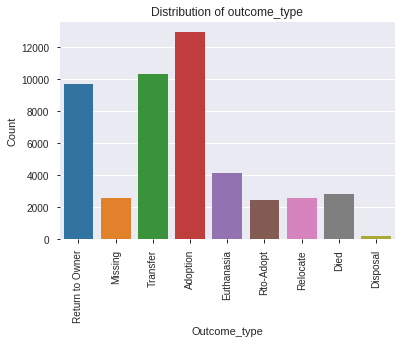

In [10]:
sns.countplot(train['outcome_type'])
plt.title("Distribution of outcome_type")
plt.xlabel("Outcome_type")
plt.ylabel("Count")
plt.xticks(rotation=90)

* Above graph describe the distribution of various output types
* Found Adoption was the top output type and disposal was bottom output type

In [11]:
train['breed'].value_counts()

Domestic Shorthair Mix                      13339
Pit Bull Mix                                 3820
Chihuahua Shorthair Mix                      2974
Labrador Retriever Mix                       2457
Domestic Medium Hair Mix                     1284
                                            ...  
Gordon Setter Mix                               1
Shiba Inu/Chinese Sharpei                       1
Pharaoh Hound/Border Collie                     1
Pembroke Welsh Corgi/Australian Shepherd        1
Miniature Schnauzer/Pug                         1
Name: breed, Length: 1847, dtype: int64

* Top 5 and bottom 5 breed

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

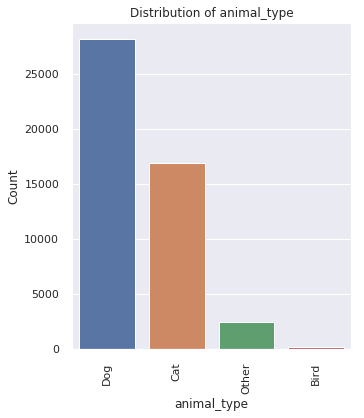

In [12]:
sns.set(rc={'figure.figsize':(5,6)})
sns.countplot(train['animal_type'])
plt.title("Distribution of animal_type")
plt.xlabel("animal_type")
plt.ylabel("Count")
plt.xticks(rotation=90)

* Above graph describe the distribution of various animal types
* Found Dog was the most frequent animal and bird was least frequent animal

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

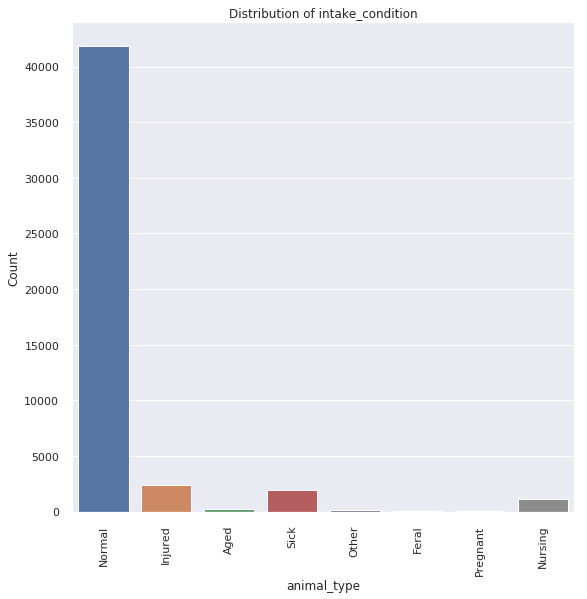

In [13]:
sns.set(rc={'figure.figsize':(9,9)})
sns.countplot(train['intake_condition'])
plt.title("Distribution of intake_condition")
plt.xlabel("animal_type")
plt.ylabel("Count")
plt.xticks(rotation=90)

* Above graph describe the distribution of various intake condition in which animal come to shelter
* Found normal was the most frequent intake condition and Ferel,Pregrant was least frequent intake condition

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

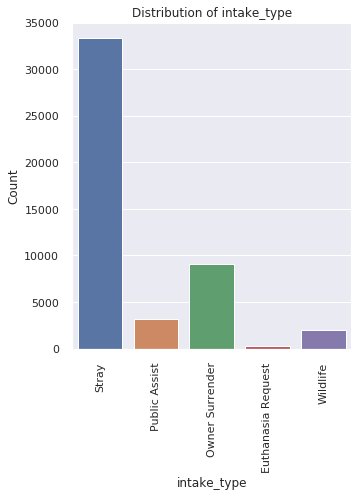

In [14]:
sns.set(rc={'figure.figsize':(5,6)})
sns.countplot(train['intake_type'])
plt.title("Distribution of intake_type")
plt.xlabel("intake_type")
plt.ylabel("Count")
plt.xticks(rotation=90)

* Above graph describe the distribution of various intake type from where the animal come to shelter
* Found Stray was the most frequent intake type and Euthanasia Request was least frequent intake type

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

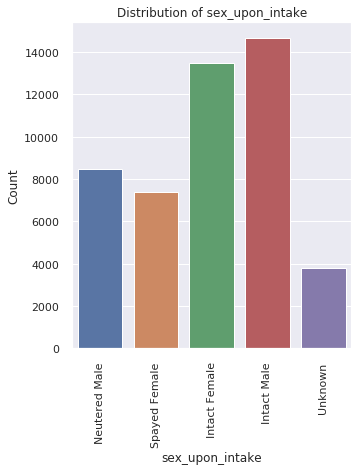

In [15]:
sns.set(rc={'figure.figsize':(5,6)})
sns.countplot(train['sex_upon_intake'])
plt.title("Distribution of sex_upon_intake")
plt.xlabel("sex_upon_intake")
plt.ylabel("Count")
plt.xticks(rotation=90)

* Above graph describe the distribution of various sex upon intake of the animal when come to shelter
* Found Intact male and Intact Female was the most frequent sex upon intake type and Unknown was least frequent sex upon intake type

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

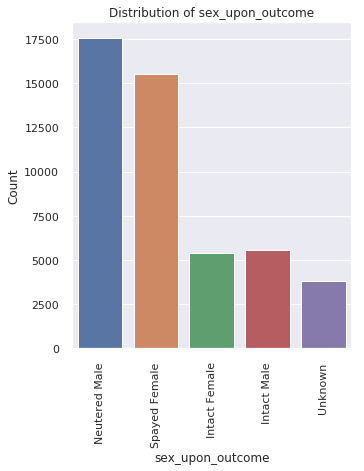

In [16]:
sns.set(rc={'figure.figsize':(5,6)})
sns.countplot(train['sex_upon_outcome'])
plt.title("Distribution of sex_upon_outcome")
plt.xlabel("sex_upon_outcome")
plt.ylabel("Count")
plt.xticks(rotation=90)

* Above graph describe the distribution of various sex upon outcome of the animal when going from shelter
* Found Neutered male and Spayed Female was the most frequent sex upon outcome and Unknown was least frequent sex upon outcome type
* Intact male and female are the most frequent sex upon intake but the neutered male and spayed Female was the most frequent sex upon outcome whick means the most Intact male animal are leaving shelter as neutered male and the most Intact female animal are leaving shelter as Spayed female 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 <a list of 45 Text xticklabel objects>)

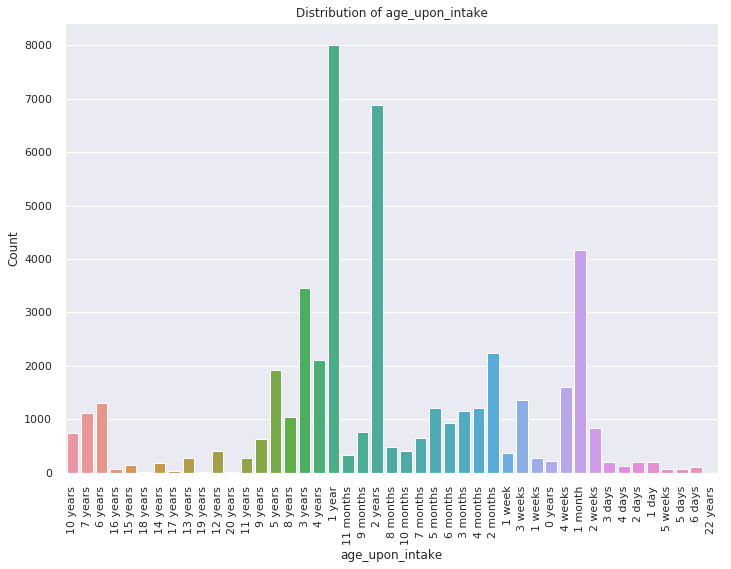

In [18]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(train['age_upon_intake'])
plt.title("Distribution of age_upon_intake")
plt.xlabel("age_upon_intake")
plt.ylabel("Count")
plt.xticks(rotation=90)

* Above graph describe the distribution of various age group at which the animal when come to shelter
* Found 1 year age was the top age upon intake type and 20,22 years was the bottom age upon intake type

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 <a list of 45 Text xticklabel objects>)

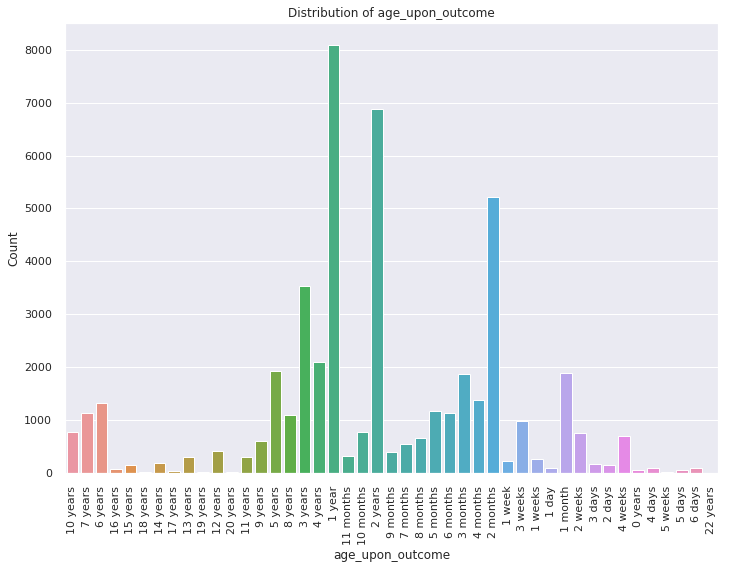

In [19]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(train['age_upon_outcome'])
plt.title("Distribution of age_upon_outcome")
plt.xlabel("age_upon_outcome")
plt.ylabel("Count")
plt.xticks(rotation=90)

* Above graph describe the distribution of various age group at which the animal going out of the shelter
* Found 1 year age was the top age upon intake type and 20,22 years was the bottom age upon intake type
* Their is small difference in above to two graphs which the 1 month animal are more at age upon intake but 2 months animal are more age upon outcome which means half of the 1 month animal leave the shelter at the age of 2 months.  

In [20]:
train.color.describe()

count           47803
unique            443
top       Black/White
freq             4975
Name: color, dtype: object

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

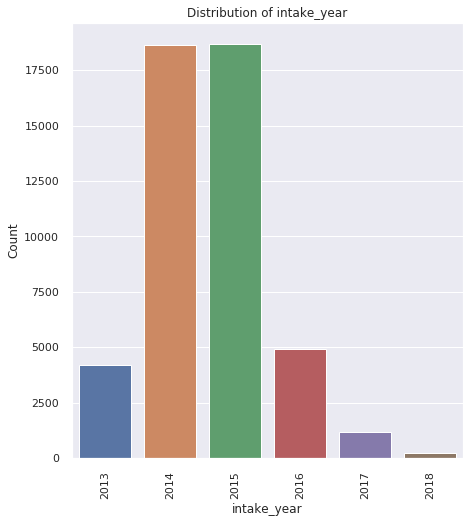

In [36]:
sns.set(rc={'figure.figsize':(7,8)})
sns.countplot(train['intake_year'])
plt.title("Distribution of intake_year")
plt.xlabel("intake_year")
plt.ylabel("Count")
plt.xticks(rotation=90)

* Above graph describe the distribution of various intake years
* Found 2014 and 2015 was the most frequent intake years and 2018 was least frequent intake year

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

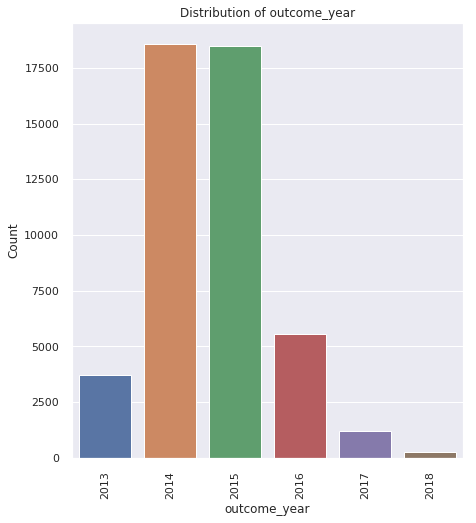

In [22]:
sns.set(rc={'figure.figsize':(7,8)})
sns.countplot(train['outcome_year'])
plt.title("Distribution of outcome_year")
plt.xlabel("outcome_year")
plt.ylabel("Count")
plt.xticks(rotation=90)

* Above graph describe the distribution of various outcome years
* Found 2014 and 2015 was the most frequent outcome years and 2018 was least frequent outcome year

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

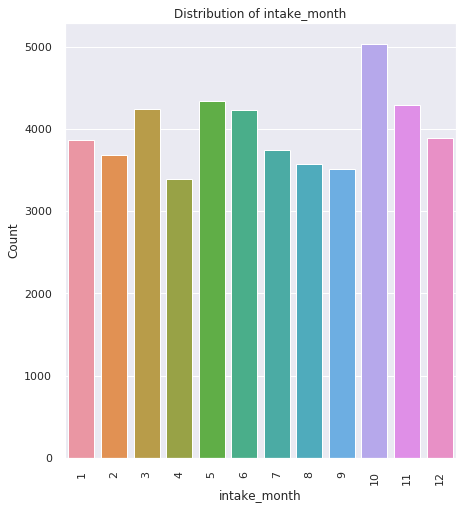

In [23]:
sns.set(rc={'figure.figsize':(7,8)})
sns.countplot(train['intake_month'])
plt.title("Distribution of intake_month")
plt.xlabel("intake_month")
plt.ylabel("Count")
plt.xticks(rotation=90)

* Above graph describe the distribution of various intake months
* Found October was the most frequent and April was least frequent intake month

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

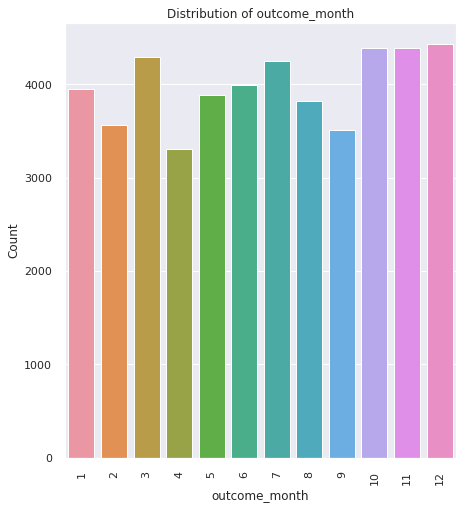

In [24]:
sns.set(rc={'figure.figsize':(7,8)})
sns.countplot(train['outcome_month'])
plt.title("Distribution of outcome_month")
plt.xlabel("outcome_month")
plt.ylabel("Count")
plt.xticks(rotation=90)

* Above graph describe the distribution of various outcome months
* Found December was the most frequent and April was least frequent outcome month

### Bi-Variate Analysis

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

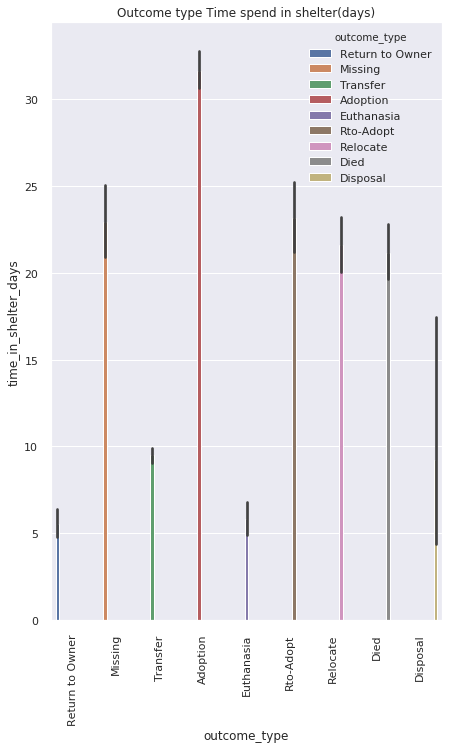

In [25]:
sns.set(rc={'figure.figsize':(7,11)})
sns.barplot(x="outcome_type", y="time_in_shelter_days", hue="outcome_type", data=train)
plt.title("Outcome type Time spend in shelter(days)")
plt.xlabel("outcome_type")
plt.ylabel("time_in_shelter_days")
plt.xticks(rotation=90)

* Above graph describe outcome type based on time spend in shelter

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

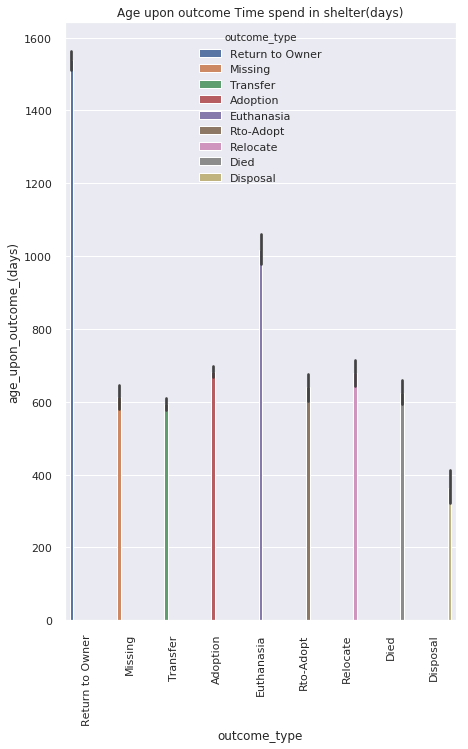

In [26]:
sns.set(rc={'figure.figsize':(7,11)})
sns.barplot(x="outcome_type", y="age_upon_outcome_(days)", hue="outcome_type", data=train)
plt.title("Age upon outcome Time spend in shelter(days)")
plt.xlabel("outcome_type")
plt.ylabel("age_upon_outcome_(days)")
plt.xticks(rotation=90)

* Above graph describe outcome type based on age_upon_outcome_(days)
* Old animals are return to the Owners

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

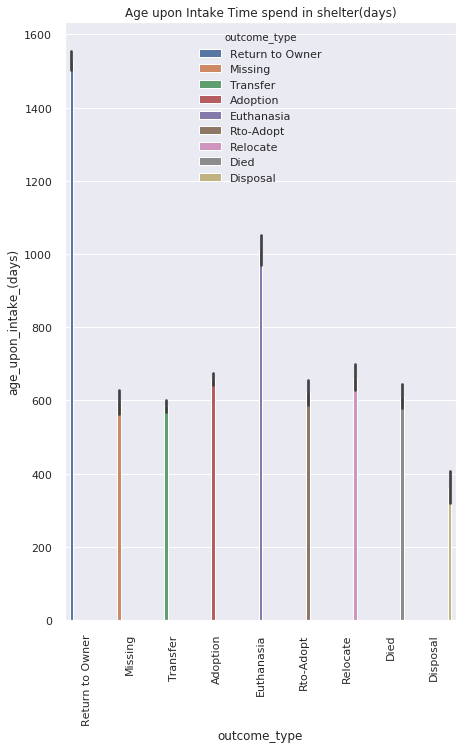

In [41]:
sns.set(rc={'figure.figsize':(7,11)})
sns.barplot(x="outcome_type", y="age_upon_intake_(days)", hue="outcome_type", data=train)
plt.title("Age upon Intake Time spend in shelter(days)")
plt.xlabel("outcome_type")
plt.ylabel("age_upon_intake_(days)")
plt.xticks(rotation=90)

* Above graph describe outcome type based on age_upon_intake_(days)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

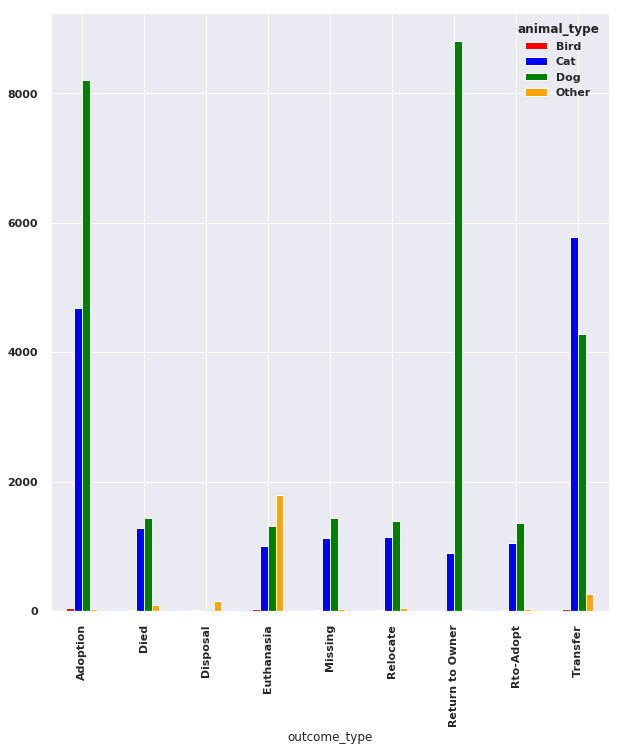

In [10]:
sns.set(rc={'figure.figsize':(10,11)})
outcomeType = train[['animal_type','outcome_type']].groupby(['outcome_type','animal_type']).size().unstack()
outcomeType.plot(kind='bar',color=['red','blue','green','orange'],rot=-30)
plt.xticks(rotation=90)

* Above graph describe outcome type based on animal type
* Dogs and cats are more adopted than bird and the other animals
* Other animals are more Euthanasia

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

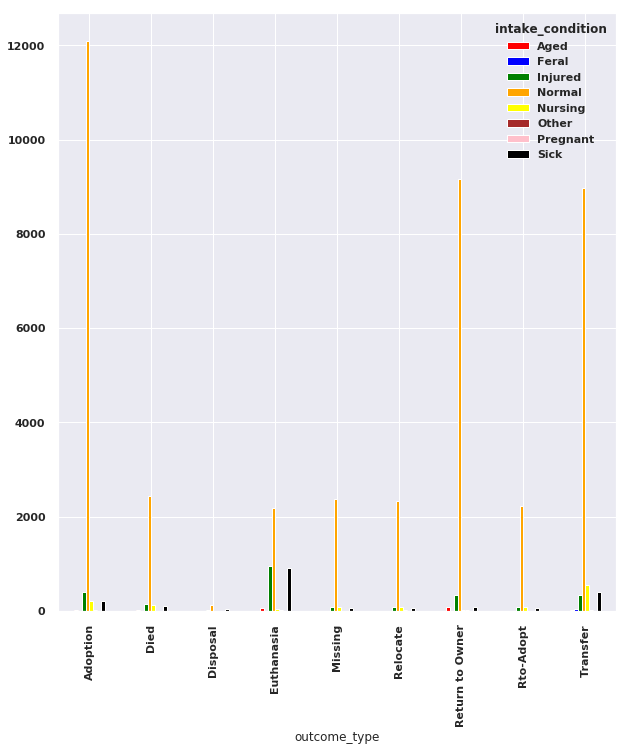

In [12]:
sns.set(rc={'figure.figsize':(10,11)})
animalType = train[['intake_condition','outcome_type']].groupby(['outcome_type','intake_condition']).size().unstack()
animalType.plot(kind='bar',color=['red','blue','green','orange','yellow','brown','pink','black'],rot=-30)
plt.xticks(rotation=90)

* Above graph describe outcome type based on intake condition
* Noraml condition dogs and cats are more adopted than the other animals

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

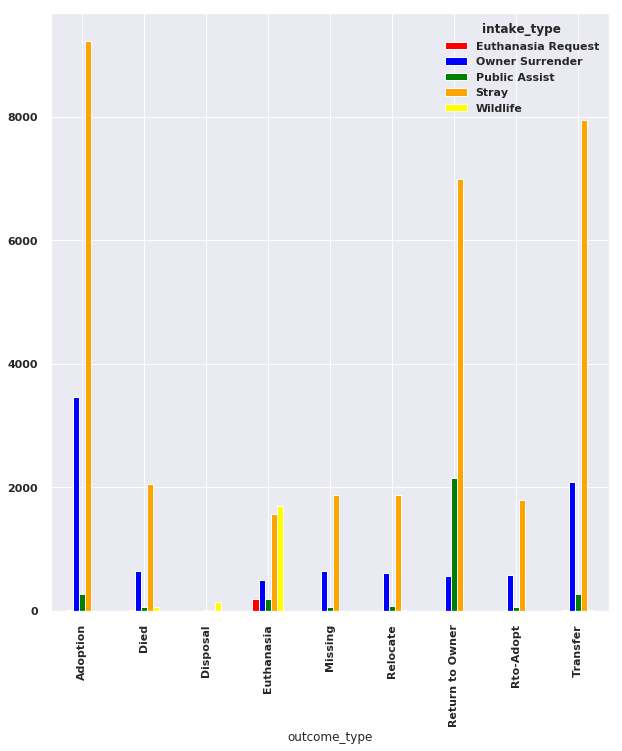

In [15]:
sns.set(rc={'figure.figsize':(10,11)})
outcomeType = train[['intake_type','outcome_type']].groupby(['outcome_type','intake_type']).size().unstack()
outcomeType.plot(kind='bar',color=['red','blue','green','orange','yellow'])
plt.xticks(rotation=90)

* Above graph describe outcome type based on intake type
* Wild animals are more Euthanasia
* Animals which are request to euthanasia are euthanasia

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

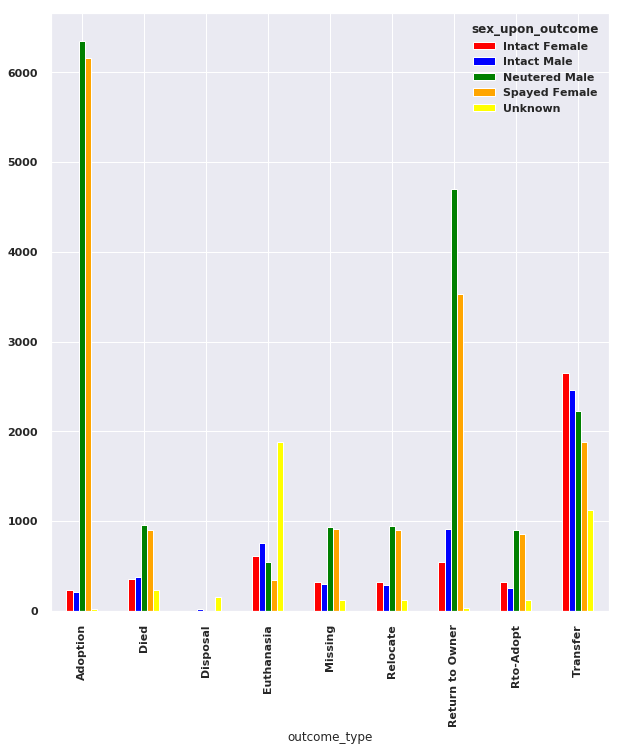

In [14]:
sns.set(rc={'figure.figsize':(10,11)})
outcomeType = train[['sex_upon_outcome','outcome_type']].groupby(['outcome_type','sex_upon_outcome']).size().unstack()
aoutcomeType.plot(kind='bar',color=['red','blue','green','orange','yellow'],rot=-30)
plt.xticks(rotation=90)

* Above graph describe outcome type based on sex_upon_outcome
* Intact feamles are more tranfered than other sex category

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

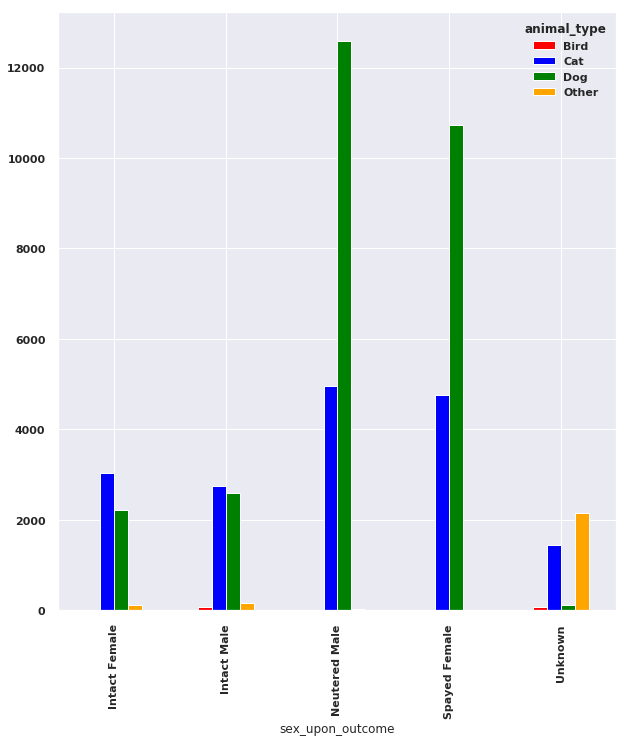

In [16]:
sns.set(rc={'figure.figsize':(10,11)})
outcomeType = train[['animal_type','sex_upon_outcome']].groupby(['sex_upon_outcome','animal_type']).size().unstack()
outcomeType.plot(kind='bar',color=['red','blue','green','orange'],rot=-30)
plt.xticks(rotation=90)

* Young dogs are likely adopted.
* Old dogs are likely returned to their owner.
* Young (older than a month) and old cats are likely adopted.
* Dogs in general are more likely to be returned to their owner than cats.
* Neutered males and spayed females are much more likely to get adopted.

##### Preprocessing 

In [3]:
train['dob_day'] = train.date_of_birth.dt.day
test['dob_day'] = test.date_of_birth.dt.day

In [4]:
train.drop(['animal_id_outcome','outcome_hour','intake_datetime','age_upon_outcome','age_upon_outcome_(years)','age_upon_outcome_age_group','outcome_datetime','outcome_monthyear','time_in_shelter'],axis = 1,inplace=True)

In [5]:
train.drop(['age_upon_intake','count','date_of_birth','age_upon_intake_(years)','age_upon_intake_age_group','intake_monthyear','intake_hour'],axis=1,inplace=True)

In [6]:
test.drop(['animal_id_outcome','outcome_hour','intake_datetime','age_upon_outcome','age_upon_outcome_(years)','age_upon_outcome_age_group','outcome_datetime','outcome_monthyear','time_in_shelter'],axis = 1,inplace=True)
test.drop(['age_upon_intake','count','date_of_birth','age_upon_intake_(years)','age_upon_intake_age_group','intake_monthyear','intake_hour'],axis=1,inplace=True)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47803 entries, 0 to 47802
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dob_year                 47803 non-null  int64  
 1   dob_month                47803 non-null  int64  
 2   animal_type              47803 non-null  object 
 3   breed                    47803 non-null  object 
 4   color                    47803 non-null  object 
 5   intake_condition         47803 non-null  object 
 6   intake_type              47803 non-null  object 
 7   sex_upon_intake          47802 non-null  object 
 8   age_upon_intake_(days)   47803 non-null  int64  
 9   intake_month             47803 non-null  int64  
 10  intake_year              47803 non-null  int64  
 11  intake_weekday           47803 non-null  object 
 12  intake_number            47803 non-null  float64
 13  time_in_shelter_days     47803 non-null  float64
 14  sex_upon_outcome      

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31869 entries, 0 to 31868
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dob_year                 31869 non-null  int64  
 1   dob_month                31869 non-null  int64  
 2   animal_type              31869 non-null  object 
 3   breed                    31869 non-null  object 
 4   color                    31869 non-null  object 
 5   intake_condition         31869 non-null  object 
 6   intake_type              31869 non-null  object 
 7   sex_upon_intake          31869 non-null  object 
 8   age_upon_intake_(days)   31869 non-null  int64  
 9   intake_month             31869 non-null  int64  
 10  intake_year              31869 non-null  int64  
 11  intake_weekday           31869 non-null  object 
 12  intake_number            31869 non-null  int64  
 13  time_in_shelter_days     31869 non-null  float64
 14  sex_upon_outcome      

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['animal_type'] = le.fit_transform(train['animal_type'])
train['breed'] = le.fit_transform(train['breed'])
train['intake_condition'] = le.fit_transform(train['intake_condition'])
train['intake_type'] = le.fit_transform(train['intake_type'])
train['sex_upon_intake'] = le.fit_transform(train['sex_upon_intake'].astype(str))
train['intake_weekday'] = le.fit_transform(train['intake_weekday'])
train['sex_upon_outcome'] = le.fit_transform(train['sex_upon_outcome'].astype(str))
train['outcome_weekday'] = le.fit_transform(train['outcome_weekday'])
train['color'] = le.fit_transform(train['color'])

test['animal_type'] = le.fit_transform(test['animal_type'])
test['breed'] = le.fit_transform(test['breed'])
test['intake_condition'] = le.fit_transform(test['intake_condition'])
test['intake_type'] = le.fit_transform(test['intake_type'])
test['sex_upon_intake'] = le.fit_transform(test['sex_upon_intake'])
test['intake_weekday'] = le.fit_transform(test['intake_weekday'])
test['sex_upon_outcome'] = le.fit_transform(test['sex_upon_outcome'])
test['outcome_weekday'] = le.fit_transform(test['outcome_weekday'])
test['color'] = le.fit_transform(test['color'])

train['outcome_type'] = le.fit_transform(train['outcome_type'])

#### Model Training

In [10]:
Y = train['outcome_type']
X = train.drop('outcome_type',axis = 1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [22]:
import xgboost as xgb

# Create XGB Classifier object
xgb_clf = xgb.XGBClassifier(tree_method = "gpu_exact", predictor = "gpu_predictor", verbosity = True,
                           eval_metric = ["merror", "map", "auc"], objective = "multi:softmax")
# Create parameter grid
parameters = {"learning_rate": [0.1, 0.02, 0.04],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [4, 6, 8, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [300, 700, 1000, 1300]}

# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
                             cv = 7, verbose = 3, random_state = 40,n_jobs=-1)

# Fit the model
model_xgboost = xgb_rscv.fit(X_train, y_train)

Fitting 7 folds for each of 10 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 21.5min finished


In [23]:
# Model best estimators
print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
print("Max Features at Split: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
print("Minimum Sum of the Instance Weight Hessian to Make a Child: ",
      model_xgboost.best_estimator_.get_params()["min_child_weight"])
print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])

Learning Rate:  0.04
Gamma:  0.3
Max Depth:  8
Subsample:  0.7
Max Features at Split:  0.6
Alpha:  0.5
Lamda:  1
Minimum Sum of the Instance Weight Hessian to Make a Child:  7
Number of Trees:  700


In [24]:
y_preds = model_xgboost.best_estimator_.predict(X_test)
print(f1_score(y_test, y_preds, average='micro'))

0.622673080945409


In [28]:
xgb_model = XGBClassifier(max_depth=8, 
                          learning_rate=0.04, 
                          n_estimators=700,  
                          objective = "multi:softmax", 
                          booster='gbtree', 
                          nthread=6, 
                          gamma=0.3, 
                          min_child_weight=7, 
                          max_delta_step=0, 
                          subsample=0.7, 
                          colsample_bytree=0.6,
                          reg_alpha=0.5, 
                          reg_lambda=1.5,
                          tree_method = "gpu_exact", 
                          predictor = "gpu_predictor",
                          seed=2020)

In [29]:
xgb_model.fit(X,Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.6, gamma=0.3, learning_rate=0.04,
              max_delta_step=0, max_depth=8, min_child_weight=7, missing=None,
              n_estimators=700, n_jobs=1, nthread=6, objective='multi:softprob',
              predictor='gpu_predictor', random_state=0, reg_alpha=0.5,
              reg_lambda=1.5, scale_pos_weight=1, seed=2020, silent=True,
              subsample=0.7, tree_method='gpu_exact')

In [32]:
y_pred = xgb_model.predict(test)

In [33]:
y_pred = le.inverse_transform(y_pred)

In [34]:
submission['outcome_type'] = y_pred

In [35]:
submission.head()

animal_id_outcome outcome_type
0           A723133     Adoption
1           A723134     Adoption
2           A723135     Adoption
3           A723136     Adoption
4           A723137     Adoption

In [36]:
submission.to_csv('xgboost_7.csv',index=False)

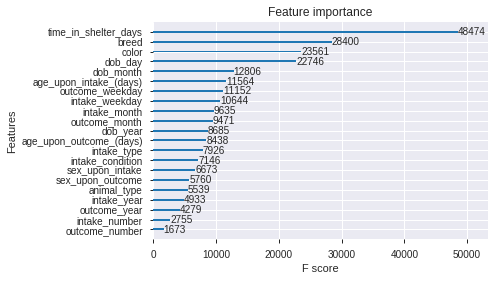

In [37]:
plot_importance(xgb_model)

* Above graph describe the which features are more important than the other